# Self-interaction of a P wave in a 1D nonlinear elastic medium

- Time-domain, explicit scheme, Spectral elements
- 1D
- Murnaghan hyperelasticity
- P-wave harmonics generation

In [1]:
import numpy as np

from dolfinx import mesh, fem, default_scalar_type
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from elastodynamicsx.pde import material, BodyForce, boundarycondition, PDE, PDECONFIG
from elastodynamicsx.solvers import TimeStepper
from elastodynamicsx.plot import plotter
from elastodynamicsx.utils import spectral_element, spectral_quadrature, make_facet_tags, make_cell_tags, ParallelEvaluator

### Set up a Spectral Element Method

In [2]:
degElement, nameElement = 4, "GLL"
PDECONFIG.default_metadata = spectral_quadrature(nameElement, degElement)

cell_type = mesh.CellType.interval
specFE = spectral_element(nameElement, cell_type, degElement, (2,))

### FE domain

In [3]:
length = 10
Nx     = 100 // degElement  # Nb of elts

# create the mesh
extent = [0, length]
domain = mesh.create_interval(MPI.COMM_WORLD, Nx, extent)

# create the function space
V = fem.FunctionSpace(domain, specFE)

# define some tags
tag_left, tag_right = 1, 2
all_tags = (tag_left, tag_right)
boundaries = [(tag_left  , lambda x: np.isclose(x[0], 0     )),\
              (tag_right , lambda x: np.isclose(x[0], length))]

facet_tags = make_facet_tags(domain, boundaries)

### Define the material law

Murnaghan's hyperelasticity. Parameters:
- $\rho$: density
- $\lambda$, $\mu$: Lamé's constants
- $l$, $m$, $n$: Murnaghan's constants

In [4]:
# parameters here...
rho     = fem.Constant(domain, default_scalar_type(1))
mu      = fem.Constant(domain, default_scalar_type(1))
lambda_ = fem.Constant(domain, default_scalar_type(2))
l_      = fem.Constant(domain, default_scalar_type(1))
m_      = fem.Constant(domain, default_scalar_type(1))
n_      = fem.Constant(domain, default_scalar_type(1))
# ... end

mat = material(V, 'murnaghan', rho, lambda_, mu, l_, m_, n_)

### Boundary conditions

- Impedance boundary condition on either edge
- Traction load $T_N$ on the left edge, with compressive $_x$ and shear $_y$ components

In [5]:
T_N = fem.Constant(domain, default_scalar_type([0, 0]))  # normal traction (Neumann boundary condition)
Z_N, Z_T = mat.Z_N, mat.Z_T  # P and S mechanical impedances
bc_l  = boundarycondition((V, facet_tags, tag_left  ), 'Neumann', T_N)
bc_rl = boundarycondition((V, facet_tags, (tag_left,tag_right) ), 'Dashpot', Z_N, Z_T)

bcs = [bc_l, bc_rl]

Define the temporal behavior of the source

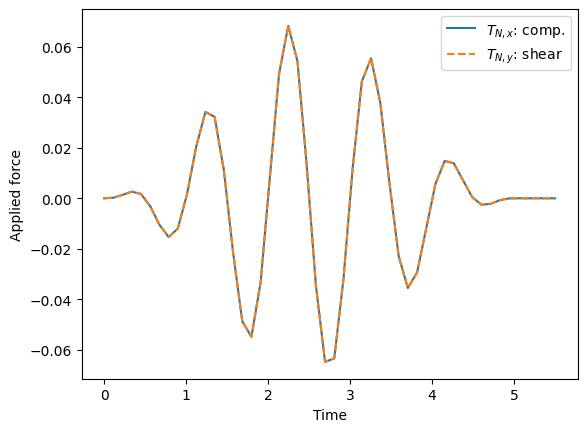

In [6]:
# -> Time function
f0 = 1       # central frequency of the source
T0 = 1 / f0  # period
d0 = 5 * T0  # duration of source

def src_t(t):  # source(t): Sine x Hann window
    window = np.sin(np.pi*t / d0)**2 * (t < d0) * (t > 0)  # Hann window
    return np.sin(2*np.pi*f0 * t) * window

# -> Space-Time function
p0  = default_scalar_type(7e-2)        # max amplitude
F_0 = p0 * default_scalar_type([1, 1])  # source orientation

def T_N_function(t):
    return src_t(t) * F_0

if domain.comm.rank == 0:
    import matplotlib.pyplot as plt
    t = np.linspace(0, 1.1 * d0)
    plt.plot(t, src_t(t) * F_0[0], label=r'$T_{N,x}$: comp.')
    plt.plot(t, src_t(t) * F_0[1], ls='--', label=r'$T_{N,y}$: shear')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Applied force')
    plt.show()

### Assemble the PDE

In [7]:
pde = PDE(V, materials=[mat], bodyforces=[], bcs=bcs)

### Time scheme

Leapfrog

In [8]:
# Temporal parameters
tstart = 0  # Start time
tmax   = 15 * T0  # Final time
num_steps = 1500
dt = (tmax - tstart) / num_steps  # time step size

# Some control numbers...
hx = length / Nx
c_S = np.sqrt(mu.value / rho.value)  # S-wave velocity
lbda0 = c_S / f0
courant_number = TimeStepper.Courant_number(V.mesh, ufl.sqrt((lambda_ + 2 * mu) / rho), dt)
PETSc.Sys.Print(f'Number of points per wavelength at central frequency: {lbda0 / hx:.2f}')
PETSc.Sys.Print(f'Number of time steps per period at central frequency: {T0 / dt:.2f}')
PETSc.Sys.Print(f'CFL condition: Courant number = {courant_number:.2f}')

# Time integration
#     diagonal=True assumes the left hand side operator is indeed diagonal
tStepper = TimeStepper.build(V, pde.m, pde.c, pde.k, pde.L, dt, bcs=bcs, scheme='leapfrog', diagonal=True)

# Set the initial values
tStepper.set_initial_condition(u0=[0, 0], v0=[0, 0], t0=tstart)

Number of points per wavelength at central frequency: 2.50
Number of time steps per period at central frequency: 100.00
CFL condition: Courant number = 0.05


### Define outputs
- Extract signals at few points
- Live-plot results (only in a terminal; not in a notebook)

In [9]:
u_res = tStepper.timescheme.u  # The solution

# -> Extract signals at few points
# Define points
points_out = np.array([[3, 0, 0], [6, 0, 0], [9, 0, 0]]).T  # shape = (3, nbpts)

# Declare a convenience ParallelEvaluator
paraEval = ParallelEvaluator(domain, points_out)

# Declare data (local)
signals_local = np.zeros((paraEval.nb_points_local,
                          V.num_sub_spaces,
                          num_steps))  # <- output stored here

# -> Define callbacks: will be called at the end of each iteration
def cbck_storeAtPoints(i, out):
    if paraEval.nb_points_local > 0:
        signals_local[:,:,i+1] = u_res.eval(paraEval.points_local, paraEval.cells_local)

# enable live plotting
enable_plot = True
clim = 0.1 * np.amax(F_0) * np.array([0, 1])
kwplot = { 'clim':clim, 'warp_factor':0.5 / np.amax(clim) }
if domain.comm.rank == 0 and enable_plot:
    p = plotter(u_res, refresh_step=10, **kwplot)
    if paraEval.nb_points_local > 0:
        # add points to live_plotter
        p.add_points(paraEval.points_local, render_points_as_spheres=True, point_size=12)
else:
    p = None

### Solve
- Define a 'callfirst' function to update the load
- Run the time loop

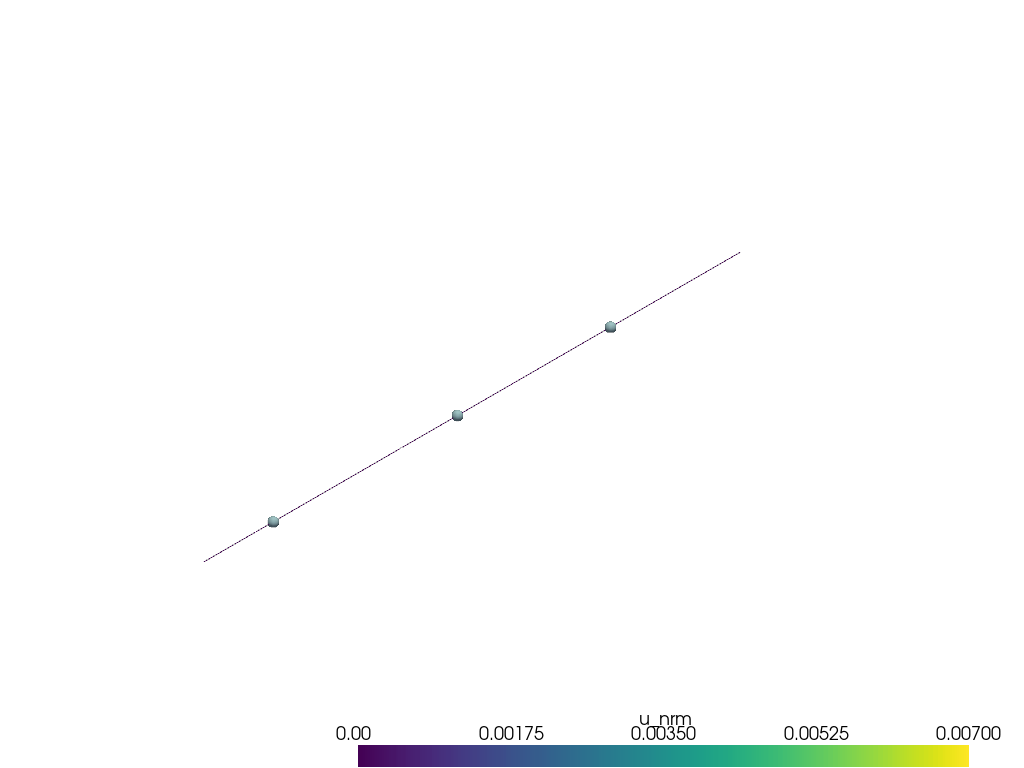

  0%|          | 0/1498 [00:00<?, ?it/s]

In [10]:
# 'callfirsts': will be called at the beginning of each iteration
def cfst_updateSources(t):
    T_N.value = T_N_function(t)

# Run the big time loop!
tStepper.solve(num_steps - 1,
               callfirsts=[cfst_updateSources],
               callbacks=[cbck_storeAtPoints],
               live_plotter=p)
# End of big calc.

### Post-processing
- Plot signals at few points

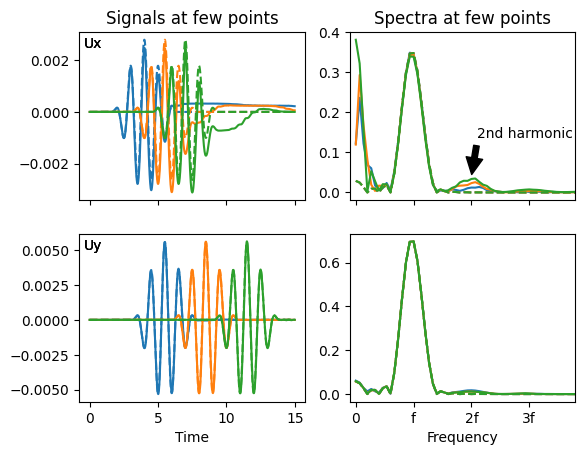

In [11]:
# Gather the data to the root process
all_signals = paraEval.gather(signals_local, root=0)

if domain.comm.rank == 0:
    ### -> Exact (linear) solution, At few points
    x = points_out.T
    t = dt*np.arange(num_steps)
    cL, cS = np.sqrt((lambda_.value+2*mu.value)/rho.value), np.sqrt(mu.value/rho.value)
    resp_L = np.cumsum( src_t(t[np.newaxis,:]-x[:,0,np.newaxis]/cL) * F_0[0]/2/cL/rho.value, axis=1)*dt
    resp_S = np.cumsum( src_t(t[np.newaxis,:]-x[:,0,np.newaxis]/cS) * F_0[1]/2/cS/rho.value, axis=1)*dt
    signals_linear = np.stack((resp_L, resp_S), axis=1)
    #
    f = np.fft.rfftfreq(t.size)/dt
    fig, ax = plt.subplots(V.num_sub_spaces,2, sharex='col', sharey='none')
    ax[0,0].set_title('Signals at few points')
    ax[0,1].set_title('Spectra at few points')
    for icomp, cax in enumerate(ax):
        for i in range(len(all_signals)):
            cax[0].text(0.02,0.97, 'U'+['x','y','z'][icomp], ha='left', va='top', transform=cax[0].transAxes)
            cax[0].plot(t, all_signals[i,icomp,:],    c='C'+str(i), ls='-' )  # FEM
            cax[0].plot(t, signals_linear[i,icomp,:], c='C'+str(i), ls='--')  # exact linear
            #
            cax[1].plot(f, np.abs(np.fft.rfft(all_signals[i,icomp,:])),    c='C'+str(i), ls='-' )  # FEM
            cax[1].plot(f, np.abs(np.fft.rfft(signals_linear[i,icomp,:])), c='C'+str(i), ls='--')  # exact linear
    specX = np.abs(np.fft.rfft(all_signals[i,0,:]))
    specX_f, specX_2f = specX[np.argmin(np.abs(f-1/T0))], specX[np.argmin(np.abs(f-2/T0))]
    ax[0, 1].annotate('2nd harmonic', xy=(2/T0, 1.2*specX_2f), xytext=(2.1/T0, 0.4*specX_f), arrowprops=dict(facecolor='black', shrink=0.05))
    ax[-1,0].set_xlabel('Time')
    ax[-1,1].set_xlabel('Frequency')
    ax[-1,1].set_xlim(-0.1*1/T0, 3.8*1/T0)
    ax[-1,1].set_xticks(np.arange(4)/T0, ['0', 'f', '2f', '3f'])
    plt.show()
#
# -----------------------------------------------------
